# Идентификация сообщений, передаваемых по зашумленному каналу связи

# 1. Последовательная передача одинаковых сообщений

## 1.1. Определение переданного сообщения

### Исходный алфавит

In [1]:
def get_alphabet(filename):
    """Считать алфавит из файла"""
    alphabet = {}
    with open(filename, encoding='utf8') as f:
        content = [x.rstrip().split('\t') for x in f.readlines()]
        alphabet = {pair[0]: pair[1] for pair in content}
    return alphabet


def get_char(alphabet: dict, code: str):
    """Найти символ по его двоичному коду"""
    for key, value in alphabet.items():
        if value == code:
            return key


def get_sorted_keys(alphabet: dict):
    """Получить алфавит, отсортированный по двоичному коду символов"""
    return [get_char(alphabet, value) for value in sorted(alphabet.values())]


In [2]:
alph = get_alphabet('alphabet.txt')
print(alph)

{'0': '0000000', '1': '0000001', '2': '0000010', '3': '0000011', '4': '0000100', '5': '0000101', '6': '0000110', '7': '0000111', '8': '0001000', '9': '0001001', 'А': '0001010', 'Б': '0001011', 'В': '0001100', 'Г': '0001101', 'Д': '0001110', 'Е': '0001111', 'Ё': '0010000', 'Ж': '0010001', 'З': '0010010', 'И': '0010011', 'Й': '0010100', 'К': '0010101', 'Л': '0010110', 'М': '0010111', 'Н': '0011000', 'О': '0011001', 'П': '0011010', 'Р': '0011011', 'С': '0011100', 'Т': '0011101', 'У': '0011110', 'Ф': '0011111', 'Х': '0100000', 'Ц': '0100001', 'Ч': '0100010', 'Ш': '0100011', 'Щ': '0100100', 'Ь': '0100101', 'Ы': '0100110', 'Ъ': '0100111', 'Э': '0101000', 'Ю': '0101001', 'Я': '0101010', 'а': '0101011', 'б': '0101100', 'в': '0101101', 'г': '0101110', 'д': '0101111', 'е': '0110000', 'ё': '0110001', 'ж': '0110010', 'з': '0110011', 'и': '0110100', 'й': '0110101', 'к': '0110110', 'л': '0110111', 'м': '0111000', 'н': '0111001', 'о': '0111010', 'п': '0111011', 'р': '0111100', 'с': '0111101', 'т': '0

Словарь априорных вероятностей:

In [3]:
n = len(alph)
p = 1 / n
priori = {char: p for char in alph}


Функция, находящая максимальное значение в словаре

In [4]:
def find_max(d: dict):
    """Найти в словаре ключ с максимальным значением"""
    return max(d, key=d.get)


### Входные данные

In [5]:
with open('input.txt', encoding='utf8') as f:
    content = f.readlines()


Колличество букв в каждом сообщении равно $s$:

In [6]:
s = int(content[0].split(': ')[1])
print('s = {s}'.format(s=s))


s = 222


Вероятность искажения каждого отдельного символа (бита) равна $q$, вероятность правильной передачи $p = 1 - q$:

In [7]:
q = float(content[2].split(': ')[1])
p = 1 - q
print('p = {p}, q = {q}'.format(p=p, q=q))


p = 0.832, q = 0.168


Колличествно сообщений (посылок) равно $m$:

In [8]:
m = int(content[3].split(': ')[1])
print('m = {m}'.format(m=m))


m = 18


In [9]:
char_num = 7 # номер буквы, которую будем исследовать в заданиях 1.2 и 2.2

### Функции для работы с вероятностями

In [10]:
import math

q = 0.168

def find_prob(x: str, y: str):
    """Найти вероятность p(y|x)"""
    assert len(x) == len(y)
    res = 1
    for i in range(len(x)):
        res = res * (1 - q if x[i] == y[i] else q)
    return res

def find_message_prob(x: dict, x_when_y: dict):
    """Найти вероятность p(y)"""
    res = 0
    for char in x_when_y:
        res = res + x_when_y[char] * x[char]
    return res

def find_posterior_probs(alph: dict, x: dict, y: str):
    """Найти вероятность p(x|y)"""
    x_when_y = alph.copy()
    for char in x_when_y.keys():
        x_when_y[char] = find_prob(alph[char], y)
    prob_y = find_message_prob(x, x_when_y)
    x_post = x.copy()
    for char in x.keys():
        x_post[char] = x_when_y[char] * x[char] / prob_y
    return x_post

def find_entropy(x: dict):
    """Найти энтропию H(X)"""
    res = 0
    for key, value in x.items():
        res = res + value * math.log2(value)
    return -res

def find_cond_entropy(alph: dict, x: dict, y: str):
    """Найти условную энтропию H(X|y)"""
    x_when_y = find_posterior_probs(alph, x, y)
    res = 0
    for key, value in x.items():
        res = res + x_when_y[key] * math.log2(x_when_y[key])
    return -res

def find_avg_entropy(alph: dict, x: dict, y: list):
    """Найти среднюю условную энтропию H(X|Y)"""
    res = 0
    for yi in y:
        x_when_y = find_posterior_probs(alph, x, yi)
        res = res + find_message_prob(x, x_when_y) * find_cond_entropy(alph, x, yi)
    return res

def find_info(alph: dict, x: dict, y: str):
    """Найти количество информации I(X:y)"""
    res = 0
    post = find_posterior_probs(alph, x, y)
    for char in x.keys():
        res = res + post[char] * math.log2(x[char])
    return -res - find_cond_entropy(alph, x, y)

def find_avg_info(alph: dict, x: dict, y: list):
    """Найти среднее количество информации I(X:Y)"""
    return find_entropy(x) - find_avg_entropy(alph, x, y)


### Все символы равновероятны

In [11]:
messages = []

for i in range(m):
    codes = content[i + 4].split(': ')[1].rstrip().split(' ')
    messages.append(codes)


In [12]:
chars = []  # вероятности появления каждого j-ого символа после i-ого сообщения
entropies = []  # значения энтропий каждого j-ого символа после i-ого сообщения
infos = []  # значения кол-ва информации об j-ом символе после i-ого сообщения

char_array = [priori.copy() for j in range(s)]  # инициализируем априорными вероятностями
chars.append(char_array)

for i in range(m):  # для каждого сообщения

    entropies_array = []
    info_array = []

    for j in range(s):  # для каждой буквы в сообщении
        entropies_array.append(find_cond_entropy(alph, chars[i][j], messages[i][j]))
        info_array.append(find_info(alph, chars[i][j], messages[i][j]))
        chars[i][j] = find_posterior_probs(alph, chars[i][j], messages[i][j])

    entropies.append(entropies_array)
    infos.append(info_array)

    if i != m - 1:  # апостериорное для текущего = априорное для следующего
        char_array = [chars[i][j].copy() for j in range(s)]
        chars.append(char_array)


In [13]:
for i in range(m):
    print(i + 1, end=': ')
    for j in range(s):
        max_char = find_max(chars[i][j])
        print(max_char, end='')
    print()


1: 8:ЛДьэчимв 4зГЩрТПизьдпПзж:ж235ц1Ё Т вжШННжпк вкБНпыпЯлдчт_заяит пЯ гХНоиб(вевЯчтЮосйиёцуЗНитЩтисШ СирелЬаМр3чЦТзШЬо,тча. Ял!ЛФтжгЯ(ЯоПсебмеЯТ! проСйЩат6(ЦУЙкРммвкеифКо ззЬа:и(й?ннелЯр.УА№Ч(рЯсяЁрн7х кадаёж2!кА(и3елаю эдЗ.
2: ДэЙА6э3Ймв 4ШФХмчьиШ4ЫРУЖжЕ_23525Зь:ЛвжШмУжнжывиПСа3пАЪЪ№У жЯ!итьпг№тЭммиЩ(вХбочУмЯТкеЖЙуЛЁег4кисШ )Ймел5Ш6СБыХТЖа5Я,ицБ4 АёяЛ,ЫеДо(опПребмЁЯТя прПВе4аУД(фДЁкнННбтеифйн(зЗЬаыи(иЁКуелЧршУ3хХЛбЯТхЁрн3х еадЮЮеА.Л9(р3Хлаю(эгП,
3: г, ДьэчЛмв 4ауЩм, изшгттпз:_23Ьъ5Зь, вЧШмжжно вкорпьпЯлучт жачет по№геориЩьвжрЯятнойтеЖМуЛЗеЫЩтисЮ (имикла рБяЦсзавовича. Азя ,тоДо потрертегс: пробе4ать)хти птмвтейфй? зРдпчи к(суелЯть!2-ШЛрЯсчетн7х жадЮния. Я(сБжлаю ,дП.
4: г:(ДьячЛов 4адЩм: илшЫртпз:_Ч35ъ4З6, вЧШмжжно вкорп пЭлучт(жачетьпг теориЩ(ЮжрЯчтнойуеЖ уЛЗикЩтина )ирикла СБяХсЖаГПвкча. АзяЛэтоДо потребтегсяьпрогешать(хуи птостейфй? зБЫачи к(сселАть!2-ШЛрасхерныщ жавЮния. Я(с3елаю ,уПВ
5: г, ДьячЛов 4ауим, из гттпз: 23Ь81_6, вжамжжно вкоро получу зачет по теорииьЮжроятнойтеК у Пик

In [14]:
import plots

for i in range(m):  # для каждого сообщения
    curr = chars[i][char_num]

    title = 'Распределение вероятностей {0}-ой буквы сообщения после {1}-ой посылки (равновероятные)'.format(char_num, i + 1)
    save = './../pics/uniform{0}.png'.format(i + 1)
    plots.draw_distribution(get_sorted_keys(alph), curr, title, show=False, save=save)


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


### Вероятности задаются исходя из частоты встречания букв в русском языке

In [15]:
with open('frequencies.txt', encoding='utf8') as f:
    content = [x.rstrip().split('\t') for x in f.readlines()]
    frequncies = {pair[0]: float(pair[1]) for pair in content}
        
print(frequncies)


{'а': 8.66, 'б': 1.51, 'в': 4.19, 'г': 1.41, 'д': 2.56, 'е': 8.1, 'ё': 0.14, 'ж': 0.78, 'з': 1.81, 'и': 7.45, 'й': 1.31, 'к': 3.47, 'л': 4.32, 'м': 3.29, 'н': 6.35, 'о': 9.28, 'п': 3.35, 'р': 5.53, 'с': 5.45, 'т': 6.3, 'у': 2.9, 'ф': 0.4, 'х': 0.92, 'ц': 0.52, 'ч': 1.27, 'ш': 0.77, 'щ': 0.49, 'ъ': 0.04, 'ы': 2.11, 'ь': 1.9, 'э': 0.17, 'ю': 1.03, 'я': 2.22}


In [16]:
def get_frequency(char: str):
    """Получить вероятноость встречания символа"""
    assert len(char) == 1
    char = char.lower()
    if char in frequncies:
        return len(frequncies) * priori[char] * frequncies[char] / sum(frequncies.values())
    else:
        return priori[char]


In [17]:
priori_weight = {key: get_frequency(key) for key in priori}
    
for key in get_sorted_keys(alph):    
    print('p(\'{0}\') = {1}'.format(key, '{0:.3f}'.format(priori_weight[key])), end=',\t')
print()
print('Sum = ' + str(sum(priori_weight.values()))) # almost == 1


p('0') = 0.011,	p('1') = 0.011,	p('2') = 0.011,	p('3') = 0.011,	p('4') = 0.011,	p('5') = 0.011,	p('6') = 0.011,	p('7') = 0.011,	p('8') = 0.011,	p('9') = 0.011,	p('А') = 0.033,	p('Б') = 0.006,	p('В') = 0.016,	p('Г') = 0.005,	p('Д') = 0.010,	p('Е') = 0.031,	p('Ё') = 0.001,	p('Ж') = 0.003,	p('З') = 0.007,	p('И') = 0.028,	p('Й') = 0.005,	p('К') = 0.013,	p('Л') = 0.016,	p('М') = 0.012,	p('Н') = 0.024,	p('О') = 0.035,	p('П') = 0.013,	p('Р') = 0.021,	p('С') = 0.021,	p('Т') = 0.024,	p('У') = 0.011,	p('Ф') = 0.002,	p('Х') = 0.003,	p('Ц') = 0.002,	p('Ч') = 0.005,	p('Ш') = 0.003,	p('Щ') = 0.002,	p('Ь') = 0.007,	p('Ы') = 0.008,	p('Ъ') = 0.000,	p('Э') = 0.001,	p('Ю') = 0.004,	p('Я') = 0.008,	p('а') = 0.033,	p('б') = 0.006,	p('в') = 0.016,	p('г') = 0.005,	p('д') = 0.010,	p('е') = 0.031,	p('ё') = 0.001,	p('ж') = 0.003,	p('з') = 0.007,	p('и') = 0.028,	p('й') = 0.005,	p('к') = 0.013,	p('л') = 0.016,	p('м') = 0.012,	p('н') = 0.024,	p('о') = 0.035,	p('п') = 0.013,	p('р') = 0.021,	p('с') = 0.021,	p('т') =

In [18]:
chars_weight = []  # вероятности появления каждого j-ого символа после i-ого сообщения
entropies_weight = []  # значения энтропий каждого j-ого символа после i-ого сообщения
infos_weight = []  # значения кол-ва информации об j-ом символе после i-ого сообщения

char_array = [priori_weight.copy() for j in range(s)]  # инициализируем априорными вероятностями
chars_weight.append(char_array)

for i in range(m):  # для каждого сообщения

    entropies_array = []
    info_array = []

    for j in range(s):  # для каждой буквы в сообщении
        entropies_array.append(find_cond_entropy(alph, chars_weight[i][j], messages[i][j]))
        info_array.append(find_info(alph, chars_weight[i][j], messages[i][j]))
        chars_weight[i][j] = find_posterior_probs(alph, chars_weight[i][j], messages[i][j])

    entropies_weight.append(entropies_array)
    infos_weight.append(info_array)

    if i != m - 1:  # априорное для следующего = постериорное для текущего
        char_array = []
        for j in range(s):
            char = chars_weight[i][j].copy()
            char_array.append(char)
        chars_weight.append(char_array)


In [19]:
for i in range(m):
    print(i + 1, end=': ')
    for j in range(s):
        max_char = find_max(chars_weight[i][j])
        print(max_char, end='')
    print()


1: 8:ЛДь9чимв 4зЕирТПизьдпПзо:_23521е Т воаНН_пк вкАНпыпЯлдчт_заяит пЯ геНоиб(вевЯчтаосиие2уЗНититиса СирелЬаМр3ч1ТзаЬо,тча. Ял!Л:тогЯ(ЯоПсебмеЯТ! проСииат6(хУикРммвкеи0Ко ззЬа:и(и?ннелЯр.!А№Ч(рЯсяерн7х када-_2!кА(и3елаА 9дЗ.
2: А:ЛА6э3инв ВаЕХр,_изЛдОоозЕ_235А5? :ЛвоШНо_но виоНаАпАлл№т за!ет!по_теооии вето№тноТЕеЖИуЛНетиоиса (иреллаЛТ3:еТИаво,очаВ Ал!Л:тоДо(ооореиоеоТ! проре4ат6(-текОоовтеи.ио(зова:и(иеОоелЯт!!А-еЛрЯТяетнИх еадАееА!та(и3елаю(,тП.
3: !, Дь,чЛмв 4ауим, изшгттпз:_23Ь85Зь, вЧаможно вкорпьпЯлучт еачет по№георииьверЯятнойтеЖМуЛЗеЫитиса (имикла рЕяЦсзавовича. Азя ,тоДо потрертегс: пробе4ать)хти птмвтеифие зРдпчи к(суелЯть!2-ШЛрЯсчетн7х оадания. Я(саелаю ,дП.
4: гЕ(Д!ячЛов Вауим, ил(Ыттпз:_23585_6, вЧамжжно(влоро полу№т зачет по теории(вероятностеК уЛПекЩтина Кирилла ряяХсИавовича, АляЛ,тоДо потреитетс! проте4ат6(хти птостейшие задачи и сселАть!2-3ЛраТчетн7х завания. а саелаю(,тПВ
5: г, ДьячЛов 4ауим, из гттпз: 23Ь81_6, воаможно вкоро получу зачет по теорииьЮероятнойтеК у Пик

In [20]:
for i in range(m):  # для каждого сообщения
    curr = chars_weight[i][char_num]

    title = 'Распределение вероятностей {0}-ой буквы сообщения после {1}-ой посылки (взвешенные вероятности)'.format(char_num, i + 1)
    save = './../pics/weighted{0}.png'.format(i + 1)
    plots.draw_distribution(get_sorted_keys(alph), curr, title, show=False, save=save)


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Из результатов видно, что в ситуации, когда вероятности задаются ихсодя из частоты встречания букв в русском языке, зашумленное сообщение было распознано немного быстрее.

## 1.2. Расчет энтропии и количества информации

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


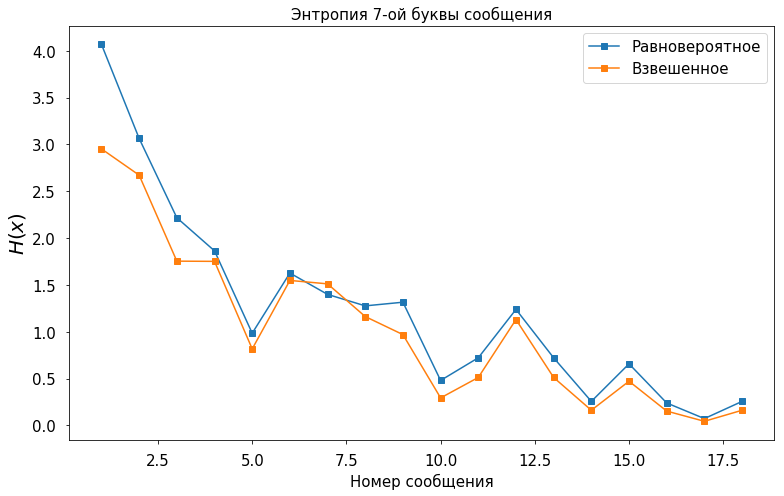

In [21]:
x = range(1, m+1)
h_u = []
h_w = []

for i in range(m):
    h_u.append(entropies[i][char_num])
    h_w.append(entropies_weight[i][char_num])
    
plots.draw_entropy(x, h_u, h_w, title='Энтропия {0}-ой буквы сообщения'.format(char_num, i + 1), save='./../pics/entropy.png')


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


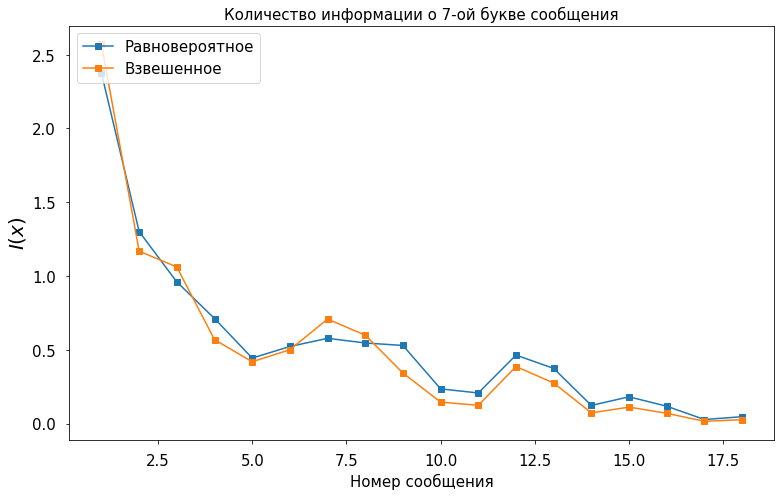

In [22]:
x = range(1, m+1)
i_u = []
i_w = []
    
for i in range(m):
    i_u.append(infos[i][char_num])
    i_w.append(infos_weight[i][char_num])
    
plots.draw_info(x, i_u, i_w, title='Количество информации о {0}-ой букве сообщения'.format(char_num, i + 1), save='./../pics/infos.png')


Средняя условная энтропия $H(X|Y)$ и среднее количество информации $I(X|Y)$: 

In [23]:
msgs = []
x_u = []
x_w = []
for i in range(m):
    x_u.append(chars[i][char_num])
    x_w.append(chars_weight[i][char_num])
    msgs.append(messages[i][char_num])
    
print('H_uniform(X|Y) = {h}'.format(h=find_avg_entropy(alph, priori, msgs)))
print('I_uniform(X:Y) = {i}'.format(i=find_avg_info(alph, priori, msgs)))
print('H_weighted(X|Y) = {h}'.format(h=find_avg_entropy(alph, priori_weight, msgs)))
print('I_weighted(X:Y) = {i}'.format(i=find_avg_info(alph, priori_weight, msgs)))

H_uniform(X|Y) = 0.861692402510141
I_uniform(X:Y) = 5.581251093338581
H_weighted(X|Y) = 1.2354422110832053
I_weighted(X:Y) = 4.7944082929790675


# Часть 2 Передача сообщения путем многократного дублирования

## Все символы равновероятны

In [24]:
long_alph = alph.copy()

for key in long_alph.keys():
    long_alph[key] = long_alph[key] * 18

In [25]:
long_chars = []  # вероятности появления каждого j-ого символа инициализируем априорными вероятностями
long_entropies = []  # значения энтропий каждого j-ого символа
long_infos = []  # значения кол-ва информации об j-ом символе
for j in range(s):
    char = priori.copy()
    long_chars.append(char)

for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    long_entropies.append(find_cond_entropy(long_alph, long_chars[j], long_char))
    long_infos.append(find_info(long_alph, long_chars[j], long_char))
    long_chars[j] = find_posterior_probs(long_alph, long_chars[j], long_char)

In [26]:
for j in range(s):
    max_char = find_max(long_chars[j])
    print(max_char, end='')
print()

Я, Дьячтов Вадим, из группы 23501_4, возможно скоро получу зачет по теории вероятностей у Никитина Кирилла Вячеславовича. Для этого потребуется прорешать эти простейшие задачи и сделать 2-3 расчетных задания. Я сделаю это!


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


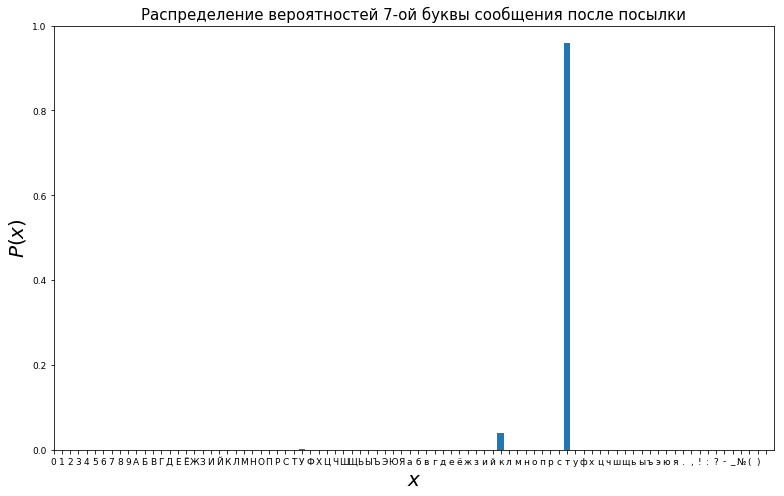

In [27]:
curr = long_chars[char_num]
    
title = 'Распределение вероятностей {0}-ой буквы сообщения после посылки'.format(char_num)
save = './../pics/long_uniform.png'
plots.draw_distribution(get_sorted_keys(long_alph), curr, title, show=True, save=save)


#### Вероятности задаются исходя из частоты встречания букв в русском языке

In [28]:
long_chars_weight = []  # вероятности появления каждого j-ого символа инициализируем априорными вероятностями
long_entropies_weight = []  # значения энтропий каждого j-ого символа
long_infos_weight = []  # значения кол-ва информации об j-ом символе
for j in range(s):
    char = priori_weight.copy()
    long_chars_weight.append(char)

for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    long_entropies_weight.append(find_cond_entropy(long_alph, long_chars_weight[j], long_char))
    long_infos_weight.append(find_info(long_alph, long_chars_weight[j], long_char))
    long_chars_weight[j] = find_posterior_probs(long_alph, long_chars_weight[j], long_char)

In [29]:
for j in range(s):
    max_char = find_max(long_chars[j])
    print(max_char, end='')
print()

Я, Дьячтов Вадим, из группы 23501_4, возможно скоро получу зачет по теории вероятностей у Никитина Кирилла Вячеславовича. Для этого потребуется прорешать эти простейшие задачи и сделать 2-3 расчетных задания. Я сделаю это!


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


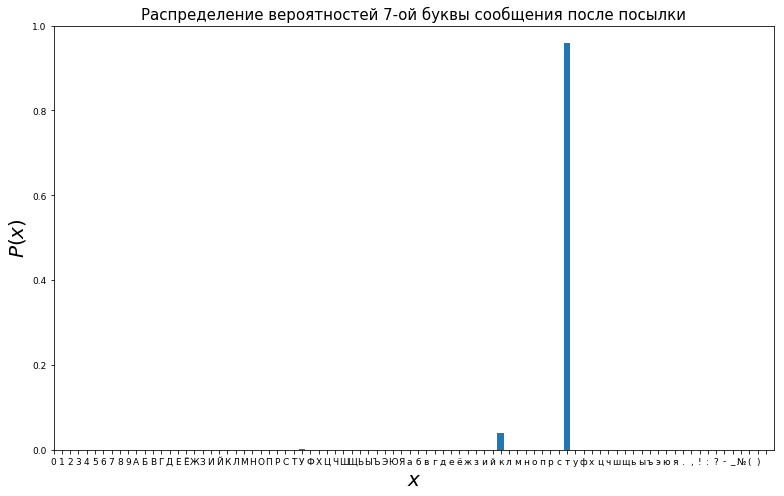

In [30]:
curr = long_chars[char_num]

title = 'Распределение вероятностей {0}-ой буквы сообщения после посылки'.format(char_num)
save = './../pics/long_uniform_weighted.png'
plots.draw_distribution(get_sorted_keys(long_alph), curr, title, show=True, save=save)

## 2.2. Расчет энтропии и количества информации

In [31]:
print('H_uniform(X|y_{i}) = {h}'.format(i=char_num, h=long_entropies[char_num]))
print('H_weighted(X|y_{i}) = {h}'.format(i=char_num, h=long_entropies_weight[char_num]))

H_uniform(X|y_7) = 0.25627958454257543
H_weighted(X|y_7) = 0.1618074336624431


In [32]:
print('I_uniform(X|y_{i}) = {inf}'.format(i=char_num, inf=long_infos[char_num]))
print('I_weighted(X|y_{i}) = {inf}'.format(i=char_num, inf=long_infos_weight[char_num]))

I_uniform(X|y_7) = 6.186663911306153
I_weighted(X|y_7) = 5.244992933882747


In [33]:
msgs = []
for j in range(s):  # для каждой буквы в сообщении
    long_char = ''
    for i in range(m):  # для каждого сообщения
        long_char = long_char + messages[i][j]
    msgs.append(long_char)


print('H_uniform(X|Y) = {h}'.format(h=find_avg_entropy(long_alph, priori, msgs)))
print('I_uniform(X:Y) = {i}'.format(i=find_avg_info(long_alph, priori, msgs)))
print('H_weighted(X|Y) = {h}'.format(h=find_avg_entropy(long_alph, priori_weight, msgs)))
print('I_weighted(X:Y) = {i}'.format(i=find_avg_info(long_alph, priori_weight, msgs)))

H_uniform(X|Y) = 0.016388735257036047
I_uniform(X:Y) = 6.426554760591687
H_weighted(X|Y) = 0.018446096662675167
I_weighted(X:Y) = 6.011404407399597
